In [15]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [16]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# bounds = "rad21_merged.bed"
bounds = "union_RAD21_CTCF.bed"
feature_of_interest = bounds

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [19]:
# bf is short for bioframe here ...
df = bf.read_table(
    feature_of_interest,
    names=["chrom","start","end"],
    usecols=(0,1,2),
    index_col=None
)
df = df.sort_values(["chrom","start"])
df = df[df["chrom"].isin(autosomal_chroms)]
df = df.reset_index(drop=True)

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


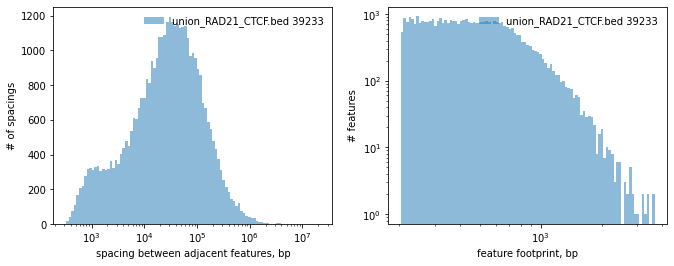

In [20]:
plot_spacing_footprint_distros({feature_of_interest:df})

### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

number of candidate features before and after merging: 39233 -> 39233


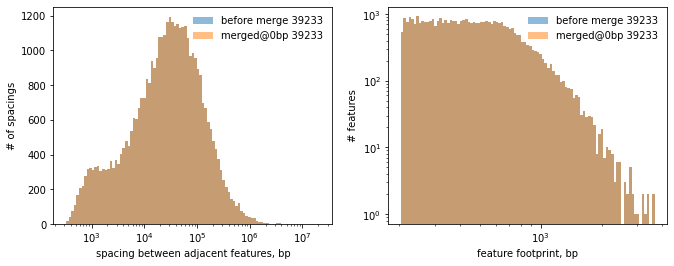

In [21]:
merge_radius = 0
df_merged = bf.merge(df, min_dist=merge_radius)
print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

plot_spacing_footprint_distros({
    "before merge":df,
    f"merged@{merge_radius}bp":df_merged,
})

### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [22]:
#let's describe our samples that we want to have in Figure 1 ...
suppfig1_samples = ["ctcf","noctcf","rad21_CTCF","rad21_noCTCF","ins_CTCF","ins_noCTCF","ev1_CTCF","ev1_noCTCF"]
titles = suppfig1_samples

bw_fnames = OrderedDict()
binsizes = {}
flanks = {}
limss = {}
cmps = {}
norms = {}
for s in suppfig1_samples:
    bw_fnames[s] = samples[s]["fname"]
    binsizes[s] = samples[s]["binsize"]
    flanks[s] = samples[s]["flank"]
    limss[s] = samples[s]["crange"]
    cmps[s] = samples[s]["cmap"]
    norms[s] = samples[s]["norm"]

### next is computation heavy step - stackups using bbi ...

In [23]:
# do all stackups with the parameters ...
stackups = {}
for s in bw_fnames:
    print(f"stacking up {s} ...")
    %time stackups[s] = rstacks( bw_fnames[s], df_merged, flank=flanks[s], binsize=binsizes[s] )

stacking up ctcf ...
CPU times: user 5.42 s, sys: 161 ms, total: 5.58 s
Wall time: 5.55 s
stacking up noctcf ...
CPU times: user 4.99 s, sys: 104 ms, total: 5.1 s
Wall time: 5.08 s
stacking up rad21_CTCF ...
CPU times: user 5.71 s, sys: 156 ms, total: 5.87 s
Wall time: 5.86 s
stacking up rad21_noCTCF ...
CPU times: user 4.5 s, sys: 148 ms, total: 4.64 s
Wall time: 4.63 s
stacking up ins_CTCF ...
CPU times: user 3.99 s, sys: 148 ms, total: 4.14 s
Wall time: 4.12 s
stacking up ins_noCTCF ...
CPU times: user 4 s, sys: 124 ms, total: 4.12 s
Wall time: 4.11 s
stacking up ev1_CTCF ...
CPU times: user 2.84 s, sys: 100 ms, total: 2.94 s
Wall time: 2.93 s
stacking up ev1_noCTCF ...
CPU times: user 2.84 s, sys: 104 ms, total: 2.94 s
Wall time: 2.94 s


### it's amazing how much you can do with a stack up !

we can flip certain rows !

_beware_ that we are reordering index this way, and we also might loos some rows from a stackup because of NaNs

In [24]:
from copy import copy
flip_stackups = copy(stackups)

### Normalize insulation stackups - subtract some value from each row in the stackup ...

In [25]:
# this is done INPLACE - be carefull !

# define the size of the shoulder - flank size
l, w = flip_stackups["ins_CTCF"].shape
norm_flank = int(w*0.25)

normalize_insulation_stackups_INPLACE(
    flip_stackups,
    [k for k in flip_stackups.keys() if k.startswith("ins")],
    subtract = "shoulders",
    subtract_size = norm_flank,
)

### sort by CTCF - to be able to distinguish between CTCF dep and CTCF indep groups ...

In [26]:
length,width = flip_stackups['ctcf'].shape
center_bin = int(width/2)
flip_stackups['ctcf_mean'] = np.nanmean(flip_stackups['ctcf'][:,center_bin-1:center_bin+1],axis=1)

ins_samples = [s for s in suppfig1_samples if s.startswith("ins")]
# insulation
for s in ins_samples:
    limss[s] = (-.19,0.02)
    cmps[s] = cmapYlGnBu_r

initial_index = np.arange( len(flip_stackups['ctcf_mean']) )
ks = [('ctcf_mean', "sort", 1, False)]
# ks = [('RAD21_mean',"sort",5),('RAD21_IAA_mean',"sort",1),  ]
_, jjj = recursive_data_ordering( ks, initial_index, flip_stackups, verbose=True)


sorting 39233 elements of ctcf_mean into 1 groups ...


### actual figure for SUpplement

#### Now sort on compartment "flip" to see A->B and B->A flips as they are ...

sorting 10000 elements of ev_middle_drop into 1 groups ...
sorting 10000 elements of ev_middle_drop into 1 groups ...


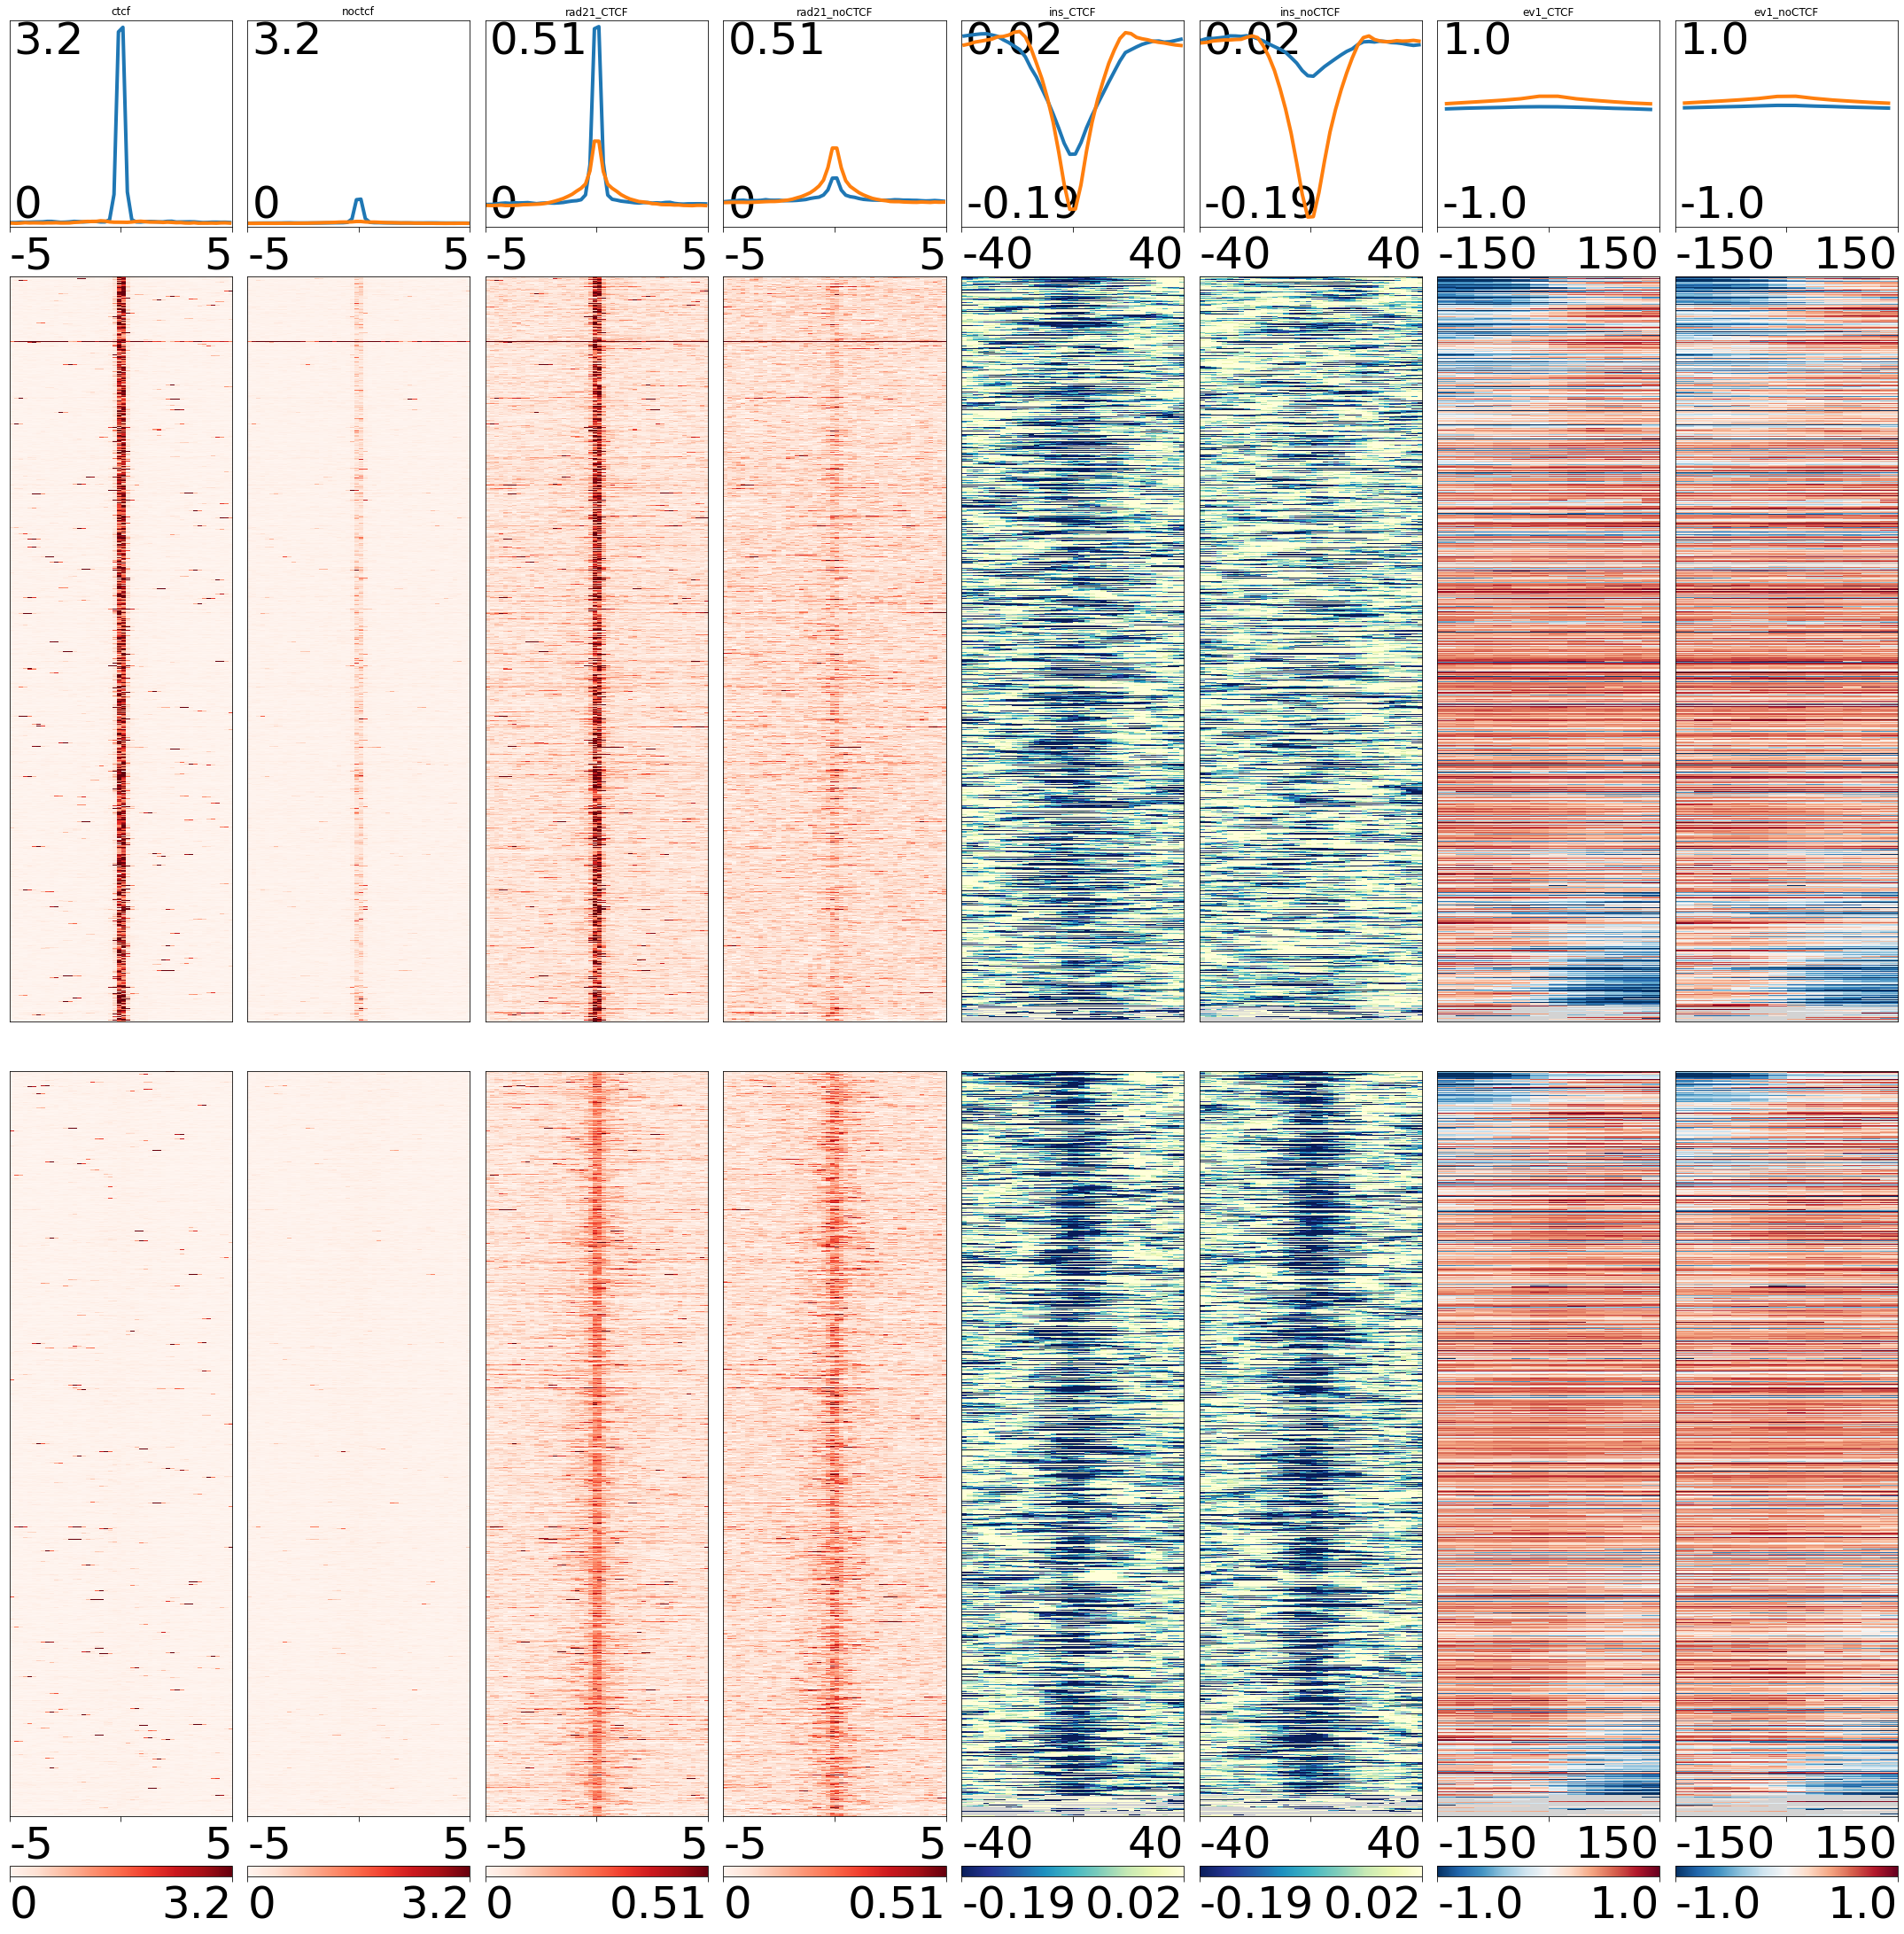

In [29]:
hmss = OrderedDict()

for iii,feature_key in zip([jjj[:10_000],jjj[-10_000:]], ['ctcf_dep', 'ctcf_indep']):
    _l, _w = flip_stackups['ctcf'].shape
    _cent = int(_w/2)
    tmp_dict = {}
    center_diff_bin =  int(flip_stackups['ev1_CTCF'].shape[1]/2)
    tmp_dict['ev_middle_drop'] = np.nanmean(flip_stackups['ev1_CTCF'][:,1:center_diff_bin],axis=1) - \
                                np.nanmean(flip_stackups['ev1_CTCF'][:,-center_diff_bin:-1],axis=1)
    tmp_dict['ev_middle_drop'] = tmp_dict['ev_middle_drop'][iii]
    ks = [('ev_middle_drop', "sort", 1, True)]
    _, iii_reord = recursive_data_ordering( ks, np.arange(len(iii)), tmp_dict, verbose=True)
    hmss[feature_key] = [ flip_stackups[_k][iii[iii_reord]] for _k in suppfig1_samples ]

_limss = [ limss[_k] for _k in suppfig1_samples ]
_cmps = [ cmps[_k] for _k in suppfig1_samples ]
_binsizes = [ binsizes[_k] for _k in suppfig1_samples ]
_norms = [ norms[_k] for _k in suppfig1_samples ]
_titles = [ t for t in titles]

extra_order = None
hmss_order = None
xtra_axs = plot_stackups_sets(extra_order,hmss,titles,_limss,_cmps,_norms,_binsizes,extra_order=extra_order,hmss_order=hmss_order,fillmissing=False,interpolation="nearest")
# xtra_axs - 2 dimensional list of axes, first index - "column"; second index is row - i.e. the stackup group

plt.savefig("SuppFigure1_EV1_November.pdf")

In [30]:
# # check what we have here locally ...
# ! ls Fig1*pdf
# ! ls master*bed
# ! ssh ghpcc ls /nl/umw_job_dekker/users/sv49w/ALV2021

! scp SuppFigure1_EV1_November.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

# !scp Fig1_masterlist* ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp masterlist*.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

SuppFigure1_EV1_November.pdf                  100% 1413KB   1.8MB/s   00:00    
